In [12]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [13]:
#making it os proof

# Get the absolute path of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

print(notebook_dir)
# Go up one level from src/ to reach project root
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

# Dataset folder path (OS-proof)
base_folder = os.path.join(project_root, "dataset", "archive")

print("Dataset folder:", base_folder)

# Sample file
actor_folder = os.path.join(base_folder, "Actor_01")
file_name = "03-01-01-01-01-01-01.wav"
file_path = os.path.join(actor_folder, file_name)

print("Full file path:", file_path)
print("File exists?", os.path.exists(file_path))


/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks
Dataset folder: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/dataset/archive
Full file path: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/dataset/archive/Actor_01/03-01-01-01-01-01-01.wav
File exists? True


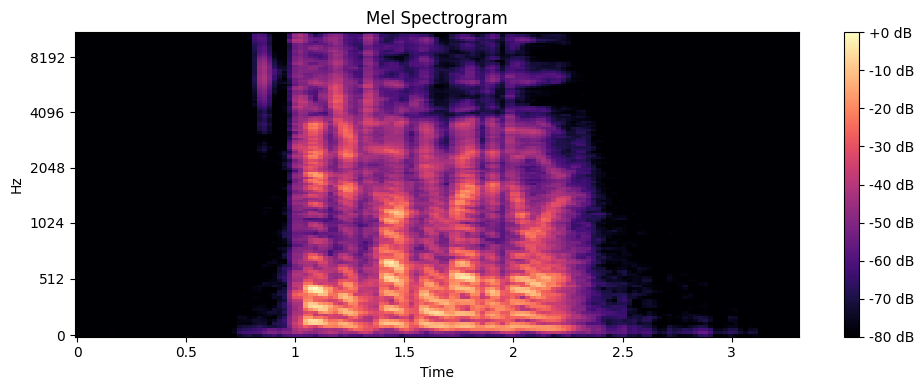

In [14]:
actor_folder=os.path.join(base_folder,"Actor_01")

file_name = "03-01-01-01-01-01-01.wav" # just a sample
file_path = os.path.join(actor_folder, file_name)

# Convert to Mel Spectrogram
signal, sr = librosa.load(path=file_path, sr=22050)
mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(S=mel, ref=np.max)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

In [15]:
all_files = []
for actor in os.listdir(base_folder):
    actor_path = os.path.join(base_folder, actor)
    if os.path.isdir(actor_path):
        for f in os.listdir(actor_path):
            if f.endswith(".wav"):
                all_files.append(os.path.join(actor_path, f))


print(all_files[0])
print("does exist?",os.path.exists(all_files[0]))

/Users/malakmaher/Documents/GitHub/Emotion-Recognition/dataset/archive/Actor_16/03-01-05-01-02-01-16.wav
does exist? True


In [16]:
import librosa
import numpy as np

def preprocess_audio(file_path, sr=22050, target_duration=3, n_mels=128, target_time_steps=128, normalize=True):
    """
    Loads an audio file, converts to fixed-size Mel spectrogram, returns TF-ready array.
    """
    #  Load audio
    signal, sr = librosa.load(file_path, sr=sr)
    
    #  Fix audio length
    target_length = int(target_duration * sr)
    if len(signal) > target_length:
        signal = signal[:target_length]
    else:
        signal = np.pad(signal, (0, target_length - len(signal)))
    
    # Compute Mel spectrogram
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    #  Resize to fixed time steps
    # Use simple interpolation
    mel_db_resized = librosa.util.fix_length(mel_db, size=target_time_steps, axis=1)
    
    #  Normalize
    if normalize:
        mel_db_resized = (mel_db_resized - mel_db_resized.min()) / (mel_db_resized.max() - mel_db_resized.min())
    
    # Add channel dimension
    mel_tf = mel_db_resized[..., np.newaxis]
    
    return mel_tf


In [17]:
EMOTION_LABELS = [
    "neutral",     # 0
    "calm",        # 1
    "happy",       # 2
    "sad",         # 3
    "angry",       # 4
    "fearful",     # 5
    "disgust",     # 6
    "surprised"    # 7
]

emotion_map = {
    1: 0,  # neutral
    2: 1,  # calm
    3: 2,  # happy
    4: 3,  # sad
    5: 4,  # angry
    6: 5,  # fearful
    7: 6,  # disgust
    8: 7   # surprised
}

def get_emotion_label(file_name):
    emotion_code = int(file_name.split("-")[2])  # Extract RAVDESS emotion
    return emotion_map[emotion_code]             # Return OUR index 0–7

In [18]:
X = []
y = []

for file_path in all_files:
    mel_tensor = preprocess_audio(file_path)   # (128,128,1)
    label = get_emotion_label(os.path.basename(file_path))  # 0–7
    X.append(mel_tensor)
    y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 5 y:", y[:5])
print("Decoded first 5 emotions:", [EMOTION_LABELS[i] for i in y[:5]])


X shape: (1440, 128, 128, 1)
y shape: (1440,)
First 5 y: [4 5 5 4 6]
Decoded first 5 emotions: ['angry', 'fearful', 'fearful', 'angry', 'disgust']


In [19]:
from sklearn.preprocessing import LabelEncoder
def load_dataset(file_paths):
    """
    Processes all audio files and returns X (Mel spectrograms) and y (numeric labels)
    
    Returns:
        X: np.ndarray of shape (num_samples, n_mels, time_steps, 1)
        y: np.ndarray of numeric labels
        label_encoder: fitted LabelEncoder object (for decoding later)
    """
    X = []
    y = []
    
    for file_path in file_paths:
        # Preprocess audio (Mel spectrogram)
        mel_array = preprocess_audio(file_path)  # TensorFlow-ready: n_mels x time_steps x 1
        X.append(mel_array)
        
        # Get label
        label = get_emotion_label(os.path.basename(file_path))
        y.append(label)
    
    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Convert labels to numeric
    le = LabelEncoder()
    y_numeric = le.fit_transform(y)
    
    return X, y_numeric, le

In [20]:
# Assuming you already have all_files
X, y, label_encoder = load_dataset(all_files)

print("X shape:", X.shape)       # (num_samples, n_mels, time_steps, 1)
print("y shape:", y.shape)       # (num_samples,)
print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))
print("First 5 labels:", y[:5])

X shape: (1440, 128, 128, 1)
y shape: (1440,)
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}
First 5 labels: [4 5 5 4 6]


In [21]:
# After building X and y lists
X = np.array(X)
y = np.array(y)

print("Before normalization:")
print("X mean:", X.mean(), "X std:", X.std())

# -------- NORMALIZATION FIX --------
mean = X.mean()
std = X.std()

X = (X - mean) / std

print("After normalization:")
print("X mean:", X.mean(), "X std:", X.std())

# Save normalized dataset
os.makedirs("data", exist_ok=True)
np.save("data/X.npy", X)
np.save("data/y.npy", y)

Before normalization:
X mean: 0.24541911 X std: 0.23765293
After normalization:
X mean: 4.3763882e-07 X std: 0.9999987


In [23]:
from tensorflow.keras.utils import to_categorical

# Ensure NUM_CLASSES is defined (use EMOTION_LABELS already in the notebook)
try:
	NUM_CLASSES
except NameError:
	NUM_CLASSES = len(EMOTION_LABELS)

y_onehot = to_categorical(y, num_classes=NUM_CLASSES)
print("One-hot encoded labels shape:", y_onehot.shape)  # (num_samples, NUM_CLASSES)

One-hot encoded labels shape: (1440, 8)
